# Testing in CLIMADA 

## set up notebook

In [6]:
import logging
import climada

logging.getLogger("climada").setLevel("WARNING")

This code here is just for this workshop so that the tests run in a notebook. No need to understand the details

In [3]:
import unittest
import warnings

def run_test(test, filterwarnings=None):

    tests = unittest.defaultTestLoader.loadTestsFromName(name=f"{test.__module__}.{test.__qualname__}")
    with warnings.catch_warnings():
        runner = unittest.TextTestRunner()
        filterwarnings and warnings.simplefilter(filterwarnings)
        result = runner.run(tests)

    return result

## Execute tests 

Who does not know how too?

In [2]:
# spoiler
! python -m unittest climada.engine.test.test_impact.TestImpact.test_pyproj_crs

2023-06-13 18:16:49,504 - climada.hazard.base - INFO - Reading C:\Users\me\climada\data\test\test_tc_florida\v1\test_tc_florida.hdf5


.
----------------------------------------------------------------------
Ran 1 test in 0.004s

OK


# Writing <del>Good</del> Better Unit/Integration Tests

## Test species for CLIMADA 

- Integration tests: located `climada_python/climada/test/` or `climada_petals/climada/test/`
- Unit tests: all other module tests

## Unit Test

<small>_not to be confused with_: `unittest` the standard test package from Python</small>

Tests whether a single function or method is doing just what it is supposed to do.

It should be possible to know the correct result of the test by calculating with a pen and paper, or ideally just looking at the test code alone.\
Do not use real datasets.\
Do not use large datasets.\
Do in general not use data files. 

Try to test some simple edge cases (e.g., negative numbers, zeroes, extra attributes,...). \
Try not to explicitly test implicit values (e.g. size of array if array values are explictly checked).

Do NOT write a test that proves only itself. I.e., if it fails in the future, one should be able to tell whether the new result is correct, or the old one. 

#### Unit test file location in climada:

climada/**/test/

### Example

Test: [TestImpactCalc.test_apply_cover_to_mat](https://github.com/CLIMADA-project/climada_python/blob/main/climada/engine/test/test_impact_calc.py#L92)

Method under test: [ImpactCalc.apply_cover_to_mat](https://github.com/CLIMADA-project/climada_python/blob/4d8fa43b42fd8322313cc0a8c8b6f347cfaeed5b/climada/engine/impact_calc.py#L451)

In [4]:
from unittest import TestCase

import numpy as np
from scipy import sparse

from climada.engine import ImpactCalc

class TestImpactCalc(TestCase):
    def test_apply_cover_to_mat(self):
        """Test methods to get insured metrics"""
        mat = sparse.csr_matrix(np.array(
            [[1, 0, 1],
             [2, 2, 0]]
            ))
        cover = np.array([0, 1, 10])
        imp = ImpactCalc.apply_cover_to_mat(mat, cover)
        np.testing.assert_array_equal(
            imp.todense(), np.array([[0, 0, 1], [0, 1, 0]])
            )

run_test(TestImpactCalc.test_apply_cover_to_mat)

.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

### Warm Up Exercise

room for improvement?

In [ ]:
# Spoiler
class TestImpactCalc(TestCase):
    def test_apply_cover_to_mat(self):
        """Test methods to get insured metrics"""
        mat = sparse.csr_matrix(np.array(
            [[1, -1, 1],  # 1) before only clipping "from above" was tested
             [2, 2, 0]]
            ))
        cover = np.array([0, 1, 10])
        imp = ImpactCalc.apply_cover_to_mat(mat, cover)
        self.assertEqual(imp.nnz, 2)  # check for zero elimination 
        np.testing.assert_array_equal(
            imp.todense(), np.array([[0, 0, 1], [0, 1, 0]])
            )

run_test(TestImpactCalc.test_apply_cover_to_mat)

.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

## Integration Test 

Test that integrate different elements of the CLIMADA code (e.g., an impact computation with an exposure, hazard and impact function). There are two kinds:

- Reference test: using real data, can be larger data sets, can take longer to test, and mostly tests that the code does not fail.\
  It checks that the result does not change over time, but not whether it is in itself correct (aka regression test).
- True integration test: looks like a unit test, but integrates different modules.

Integration tests are often used for

- I/O test for real data: try reading and writing real data sets.
- Plotting: mostly tests that plotting passes, but not that it is correct

#### Ingegration test file location in climada:

climada/test/

### Example

Test: [test_cost_benefit.TestCalc.test_calc_change_pass](https://github.com/CLIMADA-project/climada_python/blob/4d8fa43b42fd8322313cc0a8c8b6f347cfaeed5b/climada/engine/test/test_cost_benefit.py#L720)

In [7]:
import copy

from climada.hazard import Hazard
from climada.entity import Entity
from climada.engine import CostBenefit, risk_aai_agg
from climada.test import get_test_file
from climada.util.constants import ENT_DEMO_FUTURE, ENT_DEMO_TODAY

HAZ_TEST_MAT = get_test_file('atl_prob_no_name')
ENT_TEST_MAT = get_test_file('demo_today', file_format='MAT-file')

class TestCalc(unittest.TestCase):
    """Test calc"""

    def test_calc_change_pass(self):
        """Test calc with future change"""
        # present
        hazard = Hazard.from_mat(HAZ_TEST_MAT)
        entity = Entity.from_excel(ENT_DEMO_TODAY)
        entity.exposures.gdf.rename(columns={'impf_': 'impf_TC'}, inplace=True)
        entity.check()
        entity.exposures.ref_year = 2018

        # future
        ent_future = Entity.from_excel(ENT_DEMO_FUTURE)
        ent_future.check()
        ent_future.exposures.ref_year = 2040

        haz_future = copy.deepcopy(hazard)
        haz_future.intensity.data += 25

        cost_ben = CostBenefit()
        cost_ben.calc(hazard, entity, haz_future, ent_future)

        self.assertEqual(cost_ben.present_year, 2018)
        self.assertEqual(cost_ben.future_year, 2040)
        self.assertAlmostEqual(cost_ben.tot_climate_risk, 5.768659152882021e+11, places=3)

        self.assertAlmostEqual(cost_ben.imp_meas_present['no measure']['risk'],
                               6.51220115756442e+09, places=3)
        self.assertAlmostEqual(cost_ben.imp_meas_present['Mangroves']['risk'],
                               4.850407096284983e+09, places=3)
        self.assertAlmostEqual(cost_ben.imp_meas_present['Beach nourishment']['risk'],
                               5.188921355413834e+09, places=3)
        self.assertAlmostEqual(cost_ben.imp_meas_present['Seawall']['risk'],
                               4.736400526119911e+09, places=3)
        self.assertAlmostEqual(cost_ben.imp_meas_present['Building code']['risk'],
                               4.884150868173321e+09, places=3)

        self.assertAlmostEqual(cost_ben.imp_meas_future['no measure']['risk'],
                               5.9506659786664024e+10, places=3)
        self.assertAlmostEqual(cost_ben.imp_meas_future['Mangroves']['risk'],
                               4.826231151473135e+10, places=3)
        self.assertAlmostEqual(cost_ben.imp_meas_future['Beach nourishment']['risk'],
                               5.0647250923231674e+10, places=3)
        self.assertAlmostEqual(cost_ben.imp_meas_future['Seawall']['risk'],
                               21089567135.7345, places=3)
        self.assertAlmostEqual(cost_ben.imp_meas_future['Building code']['risk'],
                               4.462999483999791e+10, places=3)

        self.assertAlmostEqual(cost_ben.benefit['Mangroves'], 113345027690.81276, places=2)
        self.assertAlmostEqual(cost_ben.benefit['Beach nourishment'], 89444869971.53653, places=2)
        self.assertAlmostEqual(cost_ben.benefit['Seawall'], 347977469896.1333, places=2)
        self.assertAlmostEqual(cost_ben.benefit['Building code'], 144216478822.05154, places=2)

        self.assertAlmostEqual(cost_ben.cost_ben_ratio['Mangroves'], 0.011573232523528404)
        self.assertAlmostEqual(cost_ben.cost_ben_ratio['Beach nourishment'], 0.01931916274851638)
        self.assertAlmostEqual(cost_ben.cost_ben_ratio['Seawall'], 0.025515385913577368)
        self.assertAlmostEqual(cost_ben.cost_ben_ratio['Building code'], 0.06379298728650741)

        self.assertAlmostEqual(cost_ben.tot_climate_risk, 576865915288.2021, places=3)


run_test(TestCalc.test_calc_change_pass, "ignore")

.
----------------------------------------------------------------------
Ran 1 test in 1.232s

OK



Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.31177            113.345          86.4063
Beach nourishment          1.728               89.4449         51.7621
Seawall                    8.87878            347.977          39.192
Building code              9.2                144.216          15.6757

--------------------  ---------  --------
Total climate risk:    576.866   (USD bn)
Average annual risk:    59.5067  (USD bn)
Residual risk:        -118.118   (USD bn)
--------------------  ---------  --------
Net Present Values


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

### Improvement exercise

How could the test above be improved?

In [11]:
# spoiler
from io import StringIO
import pandas as pd

class TestCalc(unittest.TestCase):
    """Test calc"""

    def test_calc_change_pass(self):
        """Test calc with future change"""
        # present
        hazard = Hazard.from_mat(HAZ_TEST_MAT)
        entity = Entity.from_excel(ENT_DEMO_TODAY)
        entity.exposures.gdf.rename(columns={'impf_': 'impf_TC'}, inplace=True)
        entity.check()
        entity.exposures.ref_year = 2018

        # future
        ent_future = Entity.from_excel(ENT_DEMO_FUTURE)
        ent_future.check()
        ent_future.exposures.ref_year = 2040

        haz_future = copy.deepcopy(hazard)
        haz_future.intensity.data += 25

        cost_ben = CostBenefit()
        cost_ben.calc(hazard, entity, haz_future, ent_future)

        self.assertEqual(cost_ben.present_year, 2018)
        self.assertEqual(cost_ben.future_year, 2040)
        self.assertAlmostEqual(cost_ben.tot_climate_risk, 5.768659152882021e+11, places=3)
        
        expected = pd.read_csv(StringIO("""
        ,        no measure,             Mangroves,             Beach nourishment,      Seawall,               Building code
        present, 6.51220115756442e+09,   4.850407096284983e+09, 5.188921355413834e+09,  4.736400526119911e+09, 4.884150868173321e+09
        future,  5.9506659786664024e+10, 4.826231151473135e+10, 5.0647250923231674e+10, 21089567135.7345,      4.462999483999791e+10
        cbratio, , , , ,
        benefit, , , , ,
        """), skipinitialspace=True, index_col=0)
        
        for measure in expected.columns:
            self.assertAlmostEqual(cost_ben.imp_meas_present[measure]['risk'],
                                   expected.loc['present', measure], places=3)
            self.assertAlmostEqual(cost_ben.imp_meas_future[measure]['risk'],
                                   expected.loc['future', measure], places=3)
 
        self.assertAlmostEqual(cost_ben.benefit['Mangroves'], 113345027690.81276, places=2)
        self.assertAlmostEqual(cost_ben.benefit['Beach nourishment'], 89444869971.53653, places=2)
        self.assertAlmostEqual(cost_ben.benefit['Seawall'], 347977469896.1333, places=2)
        self.assertAlmostEqual(cost_ben.benefit['Building code'], 144216478822.05154, places=2)

        self.assertAlmostEqual(cost_ben.cost_ben_ratio['Mangroves'], 0.011573232523528404)
        self.assertAlmostEqual(cost_ben.cost_ben_ratio['Beach nourishment'], 0.01931916274851638)
        self.assertAlmostEqual(cost_ben.cost_ben_ratio['Seawall'], 0.025515385913577368)
        self.assertAlmostEqual(cost_ben.cost_ben_ratio['Building code'], 0.06379298728650741)

        self.assertAlmostEqual(cost_ben.tot_climate_risk, 576865915288.2021, places=3)


run_test(TestCalc.test_calc_change_pass, "ignore")

.
----------------------------------------------------------------------
Ran 1 test in 0.977s

OK



Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.31177            113.345          86.4063
Beach nourishment          1.728               89.4449         51.7621
Seawall                    8.87878            347.977          39.192
Building code              9.2                144.216          15.6757

--------------------  ---------  --------
Total climate risk:    576.866   (USD bn)
Average annual risk:    59.5067  (USD bn)
Residual risk:        -118.118   (USD bn)
--------------------  ---------  --------
Net Present Values


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

## Work with Data

### Test Files (I/O)

- **read and run**
  
    &nbsp;&nbsp;&nbsp;&nbsp; arrange _file_ \
    &nbsp;&nbsp;&nbsp;&nbsp; _file_ &rarr; _obj_ &rarr; f(_obj_) \
    &nbsp;&nbsp;&nbsp;&nbsp; assert f(_obj_) as expected
  
  unfortunate for unit tests: mixes I/O and calculation, separates data from code
  
  example: [TestImpactCalc.test_calc_impact_TC_pass](https://github.com/CLIMADA-project/climada_python/blob/4d8fa43b42fd8322313cc0a8c8b6f347cfaeed5b/climada/engine/test/test_impact_calc.py#L104)
  
- **just read**

    &nbsp;&nbsp;&nbsp;&nbsp; arrange _file_ \
    &nbsp;&nbsp;&nbsp;&nbsp; _file_ &rarr;  _obj_ \
    &nbsp;&nbsp;&nbsp;&nbsp; assert _obj_ as expected
    
  classic I/O integration test: create object from file
  
- **write** 
  
    &nbsp;&nbsp;&nbsp;&nbsp; arrange _obj_ \
    &nbsp;&nbsp;&nbsp;&nbsp; _obj_ &rarr; _file_ \
    &nbsp;&nbsp;&nbsp;&nbsp; assert _file_ as expected
  
  unfortunate 😐 files are hard to scrutinize, writing routines often depend on OS
  
- **dump-reload**
  
    &nbsp;&nbsp;&nbsp;&nbsp; arrange _obj_ \
    &nbsp;&nbsp;&nbsp;&nbsp; _obj_ &rarr; _file_ &rarr; _obj_' \
    &nbsp;&nbsp;&nbsp;&nbsp; assert _obj_ == _obj_'

  fortunate 😀 this is the preferable way of unit testing when both methods are implemented

### how to use a temporary file for dump reload

package [`tempfile`](https://docs.python.org/3/library/tempfile.html)

takes care of cleaning up afterwards

`tempfile.TemporaryDirectory` creates a directory that is removed afterwards

#### Proof of concept

In [12]:
from pathlib import Path
import tempfile

with tempfile.TemporaryDirectory() as tempdir:
    print((tempdir, Path(tempdir).is_dir()))

tempdir, Path(tempdir).is_dir()

('C:\\Users\\me\\AppData\\Local\\Temp\\tmpksak0ip9', True)


('C:\\Users\\me\\AppData\\Local\\Temp\\tmpksak0ip9', False)

#### Exercise

use the `tempfile.TemporaryDirectory()` context manager to refactor [climada.entity.disc_rates.test.test_base.TestWriter.test_write_read_pass](https://github.com/CLIMADA-project/climada_python/blob/4d8fa43b42fd8322313cc0a8c8b6f347cfaeed5b/climada/entity/disc_rates/test/test_base.py#L270) so that it does not "pollute" the local file system any more.

In [13]:
import numpy as np

from climada.util.config import Config
from climada.entity.disc_rates import DiscRates

CONFIG = Config.from_dict({"disc_rates":{"test_data": "data"}})


class TestWriter(unittest.TestCase):
    """Test excel reader for discount rates"""

    def test_write_read_pass(self):
        """Read demo excel file."""
        years = np.arange(1950, 2150)
        rates = np.ones(years.size) * 0.03
        disc_rate = DiscRates(years=years, rates=rates)

        file_name = CONFIG.disc_rates.test_data.dir().joinpath('test_disc.xlsx')
        disc_rate.write_excel(file_name)

        disc_read = DiscRates.from_excel(file_name)

        self.assertTrue(np.array_equal(disc_read.years, disc_rate.years))
        self.assertTrue(np.array_equal(disc_read.rates, disc_rate.rates))

        self.assertEqual(disc_read.tag.file_name, str(file_name))
        self.assertEqual(disc_read.tag.description, '')

run_test(TestWriter.test_write_read_pass)

.
----------------------------------------------------------------------
Ran 1 test in 0.170s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [14]:
# spoiler

class TestWriter(unittest.TestCase):
    """Test excel reader for discount rates"""

    def test_write_read_pass(self):
        """Read demo excel file."""
        years = np.arange(1950, 2150)
        rates = np.ones(years.size) * 0.03
        disc_rate = DiscRates(years=years, rates=rates)

        with tempfile.TemporaryDirectory() as tempdir:
            file_name = Path(tempdir).joinpath('test_disc.xlsx')
            disc_rate.write_excel(file_name)

            disc_read = DiscRates.from_excel(file_name)

        self.assertTrue(np.array_equal(disc_read.years, disc_rate.years))
        self.assertTrue(np.array_equal(disc_read.rates, disc_rate.rates))

        self.assertEqual(disc_read.tag.file_name, str(file_name))
        self.assertEqual(disc_read.tag.description, '')

run_test(TestWriter.test_write_read_pass)

.
----------------------------------------------------------------------
Ran 1 test in 0.096s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

### how to use the data-api for I/O integration tests

Only for the integration tests!

e.g., create objects from file

#### Example

Test: [TestStormEurope.test_icon_read](https://github.com/CLIMADA-project/climada_python/blob/main/climada/hazard/test/test_storm_europe.py#L200)

Method under test: [StormEurope.from_icon_grib](https://github.com/CLIMADA-project/climada_python/blob/4d8fa43b42fd8322313cc0a8c8b6f347cfaeed5b/climada/hazard/storm_europe.py#L396)

In [15]:
import datetime as dt
from unittest import TestCase

from scipy import sparse

from climada import CONFIG

from climada.hazard.storm_europe import StormEurope
from climada.util.api_client import Client


class TestStormEurope(TestCase):

    def test_icon_read(self):
        """test reading from icon grib"""
        # for this test the forecast file is supposed to be already downloaded from the dwd
        # another download would fail because the files are available for 24h only
        # instead, we download it as a test dataset through the climada data api
        apiclient = Client()
        ds = apiclient.get_dataset_info(name='test_storm_europe_icon_2021012800', status='test_dataset')
        dsdir, _ = apiclient.download_dataset(ds)
        haz = StormEurope.from_icon_grib(
            dt.datetime(2021, 1, 28),
            dt.datetime(2021, 1, 28),
            model_name='test',
            grib_dir=dsdir,
            delete_raw_data=False)
        self.assertEqual(haz.tag.haz_type, 'WS')
        self.assertEqual(haz.units, 'm/s')
        self.assertEqual(haz.event_id.size, 40)
        self.assertEqual(haz.date.size, 40)
        self.assertEqual(dt.datetime.fromordinal(haz.date[0]).year, 2021)
        self.assertEqual(dt.datetime.fromordinal(haz.date[0]).month, 1)
        self.assertEqual(dt.datetime.fromordinal(haz.date[0]).day, 28)
        self.assertEqual(haz.event_id[-1], 40)
        self.assertEqual(haz.event_name[-1], '2021-01-28_ens40')
        self.assertIsInstance(haz.intensity,
                              sparse.csr.csr_matrix)
        self.assertIsInstance(haz.fraction,
                              sparse.csr.csr_matrix)
        self.assertEqual(haz.intensity.shape, (40, 49))
        self.assertAlmostEqual(haz.intensity.max(), 17.276321, places=3)
        self.assertEqual(haz.fraction.shape, (40, 49))
        with self.assertLogs('climada.hazard.storm_europe', level='WARNING') as cm:
            with self.assertRaises(ValueError):
                haz = StormEurope.from_icon_grib(
                    dt.datetime(2021, 1, 28, 6),
                    dt.datetime(2021, 1, 28),
                    model_name='test',
                    grib_dir=CONFIG.hazard.test_data.str(),
                    delete_raw_data=False)
        self.assertEqual(len(cm.output), 1)
        self.assertIn('event definition is inaccuratly implemented', cm.output[0])

run_test(TestStormEurope, "ignore")

ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
.
----------------------------------------------------------------------
Ran 1 test in 4.248s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

#### Improvement Exercise

- any ideas how thiw test could be improved?

In [19]:
# spoiler
'''
- split into pass and fail
- remove relic `CONFIG.hazard.test_data`
- make the failing part a proper unit test by explicitly defining data
- ?
''';

#### Overview test data files available on API

In [16]:
c = Client()
testdata = c.list_dataset_infos(status='test_dataset')
test_files = c.into_files_df(testdata)
test_files

,data_type,data_type_group,uuid,name,version,status,doi,description,license,activation_date,...,date_creation,climada_version,spatial_coverage,year_range,res_arcsec,url,file_name,file_format,file_size,check_sum
0,measures,measures,2306fb7a-d32f-4f0b-b2f6-9ee4f0d55946,test_meas,v1,test_dataset,None,None,Attribution 4.0 International (CC-BY-4.0),None,...,NaN,NaN,NaN,NaN,NaN,https://data.iac.ethz.ch/climada/2306fb7a-d32f...,test_meas.xlsx,xlsx,5673,md5:c1a90eede3240671b73db87dc0ed9878
1,earth_engine,exposures,8cca2e12-b262-4d6c-acdb-501750322bf7,population-density_median,v1,test_dataset,None,None,Attribution 4.0 International (CC-BY-4.0),None,...,NaN,NaN,NaN,NaN,NaN,https://data.iac.ethz.ch/climada/8cca2e12-b262...,population-density_median.tif,tif,247646,md5:337eb33d7a4fd51a2e901e32fa561973
2,earth_engine,exposures,1d2a7850-9ee6-480f-b5a6-4aa13c770256,dresden,v1,test_dataset,None,None,Attribution 4.0 International (CC-BY-4.0),None,...,NaN,NaN,NaN,NaN,NaN,https://data.iac.ethz.ch/climada/1d2a7850-9ee6...,dresden.tif,tif,664471,md5:3e33539fee034a68aa626105e7a1e80f
3,base,exposures,890ea94d-ecab-4b5b-a617-2098dc930bf7,test_write_hazard,v1,test_dataset,None,None,Attribution 4.0 International (CC-BY-4.0),None,...,NaN,NaN,NaN,NaN,NaN,https://data.iac.ethz.ch/climada/890ea94d-ecab...,test_write_hazard.tif,tif,446,md5:be78239036e62a4443eedb38bf451cc8
4,impact,impact,c80c9370-777b-4f63-ad7f-9852adbb9b0a,WIOT2012_Nov16_ROW,v1,test_dataset,None,"WIOT 2012, Nov 16, ROW",Attribution 4.0 International (CC-BY-4.0),None,...,NaN,NaN,NaN,NaN,NaN,https://data.iac.ethz.ch/climada/c80c9370-777b...,WIOT2012_Nov16_ROW.xlsb,xlsb,62042190,md5:71e279a6ba7d58ff1990dd4c3f9ec61a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,base,exposures,cc078ce5-4a37-41bd-8603-2d0afaf81e60,test_point_exp,v1,test_dataset,None,None,Attribution 4.0 International (CC-BY-4.0),None,...,NaN,NaN,NaN,NaN,NaN,https://data.iac.ethz.ch/climada/cc078ce5-4a37...,test_point_exp.hdf5,hdf5,1064184,md5:cd907ac937bdd8a4759d80c0a0aa643b
119,base,exposures,c1f27aca-728b-4891-99f8-740777f35e57,test_line_exp,v1,test_dataset,None,None,Attribution 4.0 International (CC-BY-4.0),None,...,NaN,NaN,NaN,NaN,NaN,https://data.iac.ethz.ch/climada/c1f27aca-728b...,test_line_exp.hdf5,hdf5,1068184,md5:7f45d6cc6cb586a7120f97033d2f0a89
120,base,exposures,04cf37a2-261c-4094-aa95-a81349413e84,test_exposure_US_flood_random_locations,v1,test_dataset,None,None,Attribution 4.0 International (CC-BY-4.0),None,...,NaN,NaN,NaN,NaN,NaN,https://data.iac.ethz.ch/climada/04cf37a2-261c...,test_exposure_US_flood_random_locations.hdf5,hdf5,1065360,md5:8b2ac82188da9fed60fcfdf6dad96f13
121,river_flood,hazard,c17f8cdd-6a9b-4aaa-83b5-ceea6e8b1df0,test_hazard_US_flood_random_locations,v1,test_dataset,None,None,Attribution 4.0 International (CC-BY-4.0),None,...,2022-07-01,v3.1.2,country,NaN,150,https://data.iac.ethz.ch/climada/c17f8cdd-6a9b...,test_hazard_US_flood_random_locations.hdf5,hdf5,1063139,md5:44b005d8f3eeab8ed6b0627517c69685


### how to use data files in the repository for testing

Not! 😝

# Time for some exercises! 

Take some tests in CLIMADA, and refactor the unit tests, move parts to the integration tests, refactor integration tests.

- replace big default test data with concise test data
- replace test data read from file with test data defined on the spot
- implement dump reload tests with `tempfile`
- clean up tests with side effects
- implement `__eq__` and use it for assertions
- add missing test cases
- remove superfluous test cases

# Extra infos

## Test Cases

### Parameter Test Set

- Each parameter should be covered in test cases by as many values as there are qualitative ditinctions

**Example**

- How many test cases do we need for `f`? 

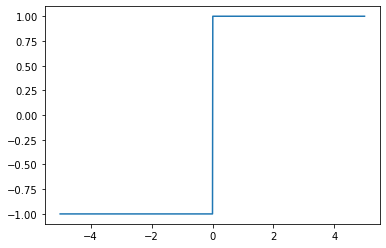

In [30]:
import numpy as np
from matplotlib import pyplot as plt

def f(x):
    if x < 0: return -1
    if x > 0: return +1
    return 0

xa = np.arange(-5,5,0.01)
ya = np.array([f(x) for x in xa])
              
plt.plot(xa, ya);

### Should `None` be in the test set?

- Null pointer exceptions are notoriously hard to debug and very annoying.
- However - the `NoneType` is only another type and Python is not a type safe language. We cannot test _everyghing_.
- Suggestion: Check only if it's (implicitly or explicitly) part of the method description.

### Combinatorics

```
def f(a: A, b: B, c: C):
    ...
```

- Full parameter space, nominally: `A x B x C` \
  _watch out_! this is often _de facto_ `(A | B) x C`
- make sure each parameter is covered by itself sufficiently\
  and combinations are covered if they are linked, i.e., _if they make a difference together_.
- many parameters? think about refactoring!


### Bottom line

- test all valid cases that make a difference

## Arrange

Aim for 
- minimal objects
- containing crucial data
- illustrating the case
- defined on the spot

## Assert

### Checking Results

comparing an expected result with the actual may be cumbersome:

```
e = expected()
r = calculated()

assert r.x == e.x
assert r.y == e.y
assert len(r.z) == len(e.z)
...

```

- it's easy to lose track
- changes in target demand that each such test must be updated

Example: [TestImpactCalc.test_calc_impact_TC_pass](https://github.com/CLIMADA-project/climada_python/blob/4d8fa43b42fd8322313cc0a8c8b6f347cfaeed5b/climada/engine/test/test_impact_calc.py#L104)

#### Check equality if possible

- e.g., dataclasses: if `__eq__` is overwritten to compare _value_ instead of _id_, this can be shortened to

```
e = expected()
r = calculated()

assert r == e

```

- advantage: complete test, not depending on random samples, when target changes, only `__eq__` must be updated.
- downside: performance may be an issue.

#### Custom helper method

- when overwriting `__eq__` is not an option, we can still isolate the comparison and equality check in a helper method.

Example: [climada.util.test.test_lines_polys_handler](https://github.com/CLIMADA-project/climada_python/blob/4d8fa43b42fd8322313cc0a8c8b6f347cfaeed5b/climada/util/test/test_lines_polys_handler.py#L68)

### Check for errors thrown

- thrown exceptions are, i.g., corner cases worth testing
- i.g., do not check for exceptions raised by called methods.

Example: [entity.disc_rates.test.test_base.TestChecker.test_check_wrongRates_fail](https://github.com/CLIMADA-project/climada_python/blob/4d8fa43b42fd8322313cc0a8c8b6f347cfaeed5b/climada/entity/disc_rates/test/test_base.py#L32)

### Check for log content

(errors/warnings/infos)

- i.g. not to be tested

Exceptions:

- it _is_ important for the user
- it is a means of checking the behavior of the method. (In this case mocking may be an alternative.)

Example: [util.test.test_dwd_icon.TestDeleteIcon.test_file_not_exist_warning](https://github.com/CLIMADA-project/climada_python/blob/4d8fa43b42fd8322313cc0a8c8b6f347cfaeed5b/climada/util/test/test_dwd_icon.py#L86)

### Testing Plot Functions

Testing plot functions _properly_ is demanding!

Suggestions:

- stick to regression tests, i.e. just check for making plots without raising an Exception
- mock ?
- ai ?

## Mocking

In most cases the target method calls other methods.\
In theory a unit test must not care whether these methods further down are correct or not.\
In practice it often doesn't matter.

Where it does matter:

- the called methods access external resources (e.g., `requests.get()`)
- the called methods are expensive
- the tested method is primarily a wrapper around other methods\
  (juggling arguments)
  
For these cases you can use a _Mock_ (or _Stub_) object. These do not really do anything but take arguments and provide predefined results for testing purposes.

The difference between _Mock_ and _Stub_ is that _Mock_ additionally keeps track of the methods that were called and the arguments that were provided during the test. After the test has been performed the _Mock_ object can be inspected for this information.

package: [unittest.mock](https://docs.python.org/3/library/unittest.mock.html)

In [1]:
from unittest.mock import patch, ANY

side_effects = []

class A():
    def do_something(self, *args, **kwargs):
        side_effects.append(1)
        return args, kwargs

with patch("__main__.A.do_something") as do_something_else:
    # within this context block, `do_something` returns a predefined result
    do_something_else.return_value = 0, {}
    t = A()
    print("mocked:", t.do_something(1, 2, k=A()))

# from here on `do_something` works normally again
print("reset:", t.do_something(1, 2, k=A()))

# inspect call history
do_something_else.assert_called_once_with(1, 2, k=ANY)  # using A() instead of ANY raises an exception: A() == A() is False!

side_effects

mocked: (0, {})
reset: ((1, 2), {'k': <__main__.A object at 0x0000027C0DB535E0>})


[1]

example: [hazard.test.test_base_xarray.TestReadDimsCoordsNetCDF.test_load_dataset_rechunk](https://github.com/CLIMADA-project/climada_python/blame/4d8fa43b42fd8322313cc0a8c8b6f347cfaeed5b/climada/hazard/test/test_base_xarray.py#L471)

# Take Home Message

if writing tests for an existing method turns out to be hard work, consider refactoring the method!